# Importing Datasets, Loading Required Libraries observe the dataset information

In [1]:
# Importing Necessary libraries

import numpy as np 
import pandas as pd 
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mushroom-classification/mushrooms.csv


In [3]:
# Loading dataset
df = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')

#get to know about the shape
df.shape

(8124, 23)

In [4]:
# Checking if duplicate column exist in dataset
df.columns.duplicated().sum()

0

In [5]:
#checkig if duplicate rows exist in dataset
df.T.columns.duplicated().sum()

0

In [6]:
# Checkig the number of unique value in each column
df.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

In [7]:
df.sample(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
716,e,b,s,w,t,l,f,c,b,k,...,s,w,w,p,w,o,p,n,s,m
6469,p,k,s,n,f,f,f,c,n,b,...,s,p,w,p,w,o,e,w,v,l
1173,e,x,f,n,f,n,f,c,n,g,...,s,w,w,p,w,o,p,k,v,u
3598,e,f,y,n,t,n,f,c,b,n,...,s,p,g,p,w,o,p,k,y,d
735,e,b,y,w,t,a,f,c,b,w,...,s,w,w,p,w,o,p,n,s,g


In [8]:
# Dropping Veil-type column

df = df.drop('veil-type',axis = 1)

# Crammer's V Concepts and Implementation with loaded datasets

**Crammer's V**

An effect size metric for the chi-square test of independence is called Cramér's V. It gauges the degree of correlation between two category fields.

Crammer's V is computed by taking the square root of the chi-squared statistic divided by the sample size and the minimum dimension minus 1:


> $$ V = \sqrt \frac{\varphi^{2}}{min(k-1 , r-1)} $$



where:
> $$ {\varphi} {\; is\; the\; phi \;coefficient\;} $$
> $$ {\chi^{2}} {\; is\; result \; from\; Pearson's\; chi-squared\; test\;} $$
> $$ {n} {\; is\; total\; number \; observation\;} $$
> $$ {k} {\; numbers\; of\; column} $$
> $$ {r} {\; numbers\; of\; rows} $$

Calculatig phi coefficient

> $$ phiSq =  {\frac{\chi^{2}}{n}} $$


> $$ \varphi^{2} = \max(0, phiSq - \frac{(k-1)(r-1)}{(n-1)}) $$

In [9]:
def cramerV(data_crosstab):
    total = data_crosstab.sum().sum()
    chi2 = stats.chi2_contingency(data_crosstab)[0]
    phi2 = chi2/total
    r, k = data_crosstab.shape

    phi2corr = max(0,phi2-((k-1)*(r-1))/(total-1))
    rcorr = r-((r-1)**2)/(total-1)
    kcorr = k-((k-1)**2)/(total-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))    

In [10]:
#  Storing the result in dictionary after calculation of cramer value of every columns with target i.e class

cramerValue = {}

for col in df.columns:
    data_crosstab = pd.crosstab(df[col], df['class'])
    data = cramerV(data_crosstab)
    cramerValue[col] = data

In [11]:
# Storing values from cramerValue in dataset so that data vizualization would be efficient
cv = pd.DataFrame()
cv['values'] = cramerValue.values()
cv['key'] = cramerValue.keys()
cv.set_index('key', inplace=True)
cv_sorted_val = cv.sort_values(by='values').T

<Axes: xlabel='key'>

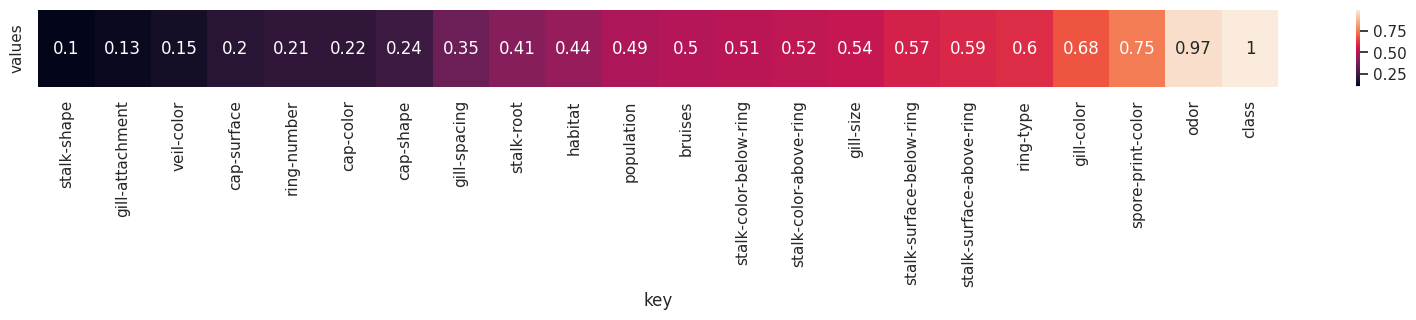

In [12]:
sns.set_theme()
plt.figure(figsize=(20,1))
sns.heatmap(cv_sorted_val, annot=True)

**Insights**
- Only 3 column are strongly corelated with our target/class
- Lets check how much co relation occurs between gill-color, spore-print-color and order with one another
    - we can see that:
        - odor and spore-print-color are corelated with the score 0.3953
        - odor and gill-color are corelated with the score 0.388
        - spore-print-color and gill-color are corelated with the score 0.4840
        

# Create New dataset with high Crammer's value

In [13]:
data_crosstab = pd.crosstab(df['spore-print-color'], df['gill-color'])
data = cramerV(data_crosstab)
data

0.4840832004820434

In [14]:
data_crosstab = pd.crosstab(df['gill-color'], df['odor'])
data = cramerV(data_crosstab)
data

0.38871224909583646

In [15]:
data_crosstab = pd.crosstab(df['odor'], df['spore-print-color'])
data = cramerV(data_crosstab)
data

0.3953398596906631

In [16]:
# Creating new dataframe with the column which are highly co related
new_df = pd.DataFrame()

new_df['odor'] =df['odor']
new_df['spore-print-color'] =df['spore-print-color']
new_df['gill-color'] =df['gill-color']
new_df['class'] =df['class']

In [17]:
# Getting Unique data in each column
new_df.nunique()

odor                  9
spore-print-color     9
gill-color           12
class                 2
dtype: int64

# Feature Engineering with newly created dataset

**Working with Odor**

<Axes: xlabel='odor', ylabel='count'>

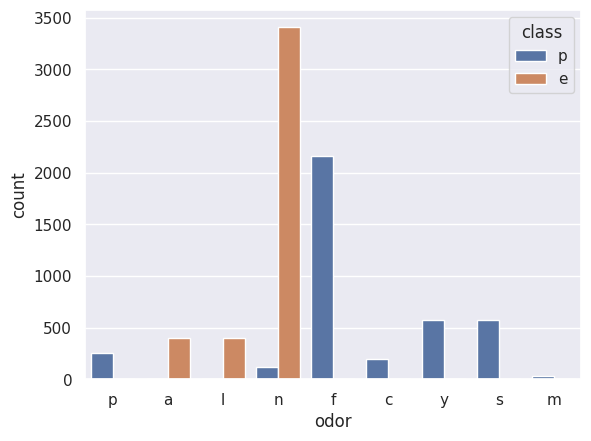

In [18]:
# new_df.groupby('odor')['class'].value_counts()
sns.countplot(x="odor",data=new_df, hue='class')

<Axes: xlabel='odor', ylabel='count'>

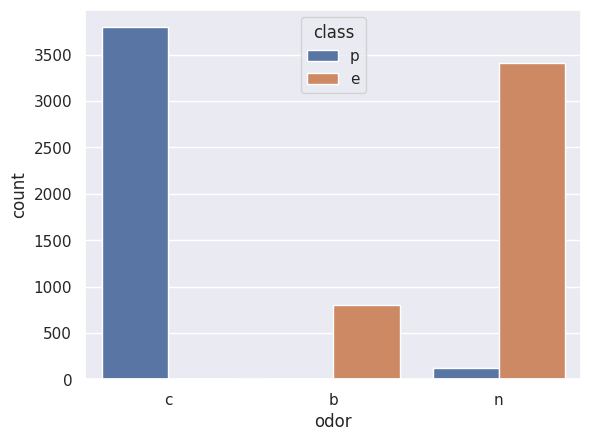

In [19]:
# Output of all ['p','f','c','y','s','m'] is poisionious and output of all ['a','l'] is edible. So renaming them with one unique value respwctively
new_df['odor'] = new_df['odor'].replace(['p','f','c','y','s','m'], 'c')
new_df['odor'] = new_df['odor'].replace(['a','l'], 'b')

# Then output would look like:
# This will help to reduce colum during one hot encoding
sns.countplot(x="odor",data=new_df, hue='class')

**Working with gill-color**

In [20]:
# new_df.groupby('gill-color')['class'].value_counts()
# sns.countplot(x="gill-color",data=new_df, hue='class')

In [21]:
# new_df['gill-color'] = new_df['gill-color'].replace(['b','r'], 'f')
# new_df['gill-color'] = new_df['gill-color'].replace(['e','o'], 'q')
# new_df['gill-color'] = new_df['gill-color'].replace(['k','w','y'], 'z')
# new_df['gill-color'] = new_df['gill-color'].replace(['u','n'], 'u')
# new_df['gill-color'] = new_df['gill-color'].replace(['g','h'], 'h')

# sns.countplot(x="gill-color",data=new_df, hue='class')

# Accuracy, precision recall remain same even if this column is removed
new_df.drop('gill-color', axis=1, inplace = True)

**Working With spore-print-color**

<Axes: xlabel='spore-print-color', ylabel='count'>

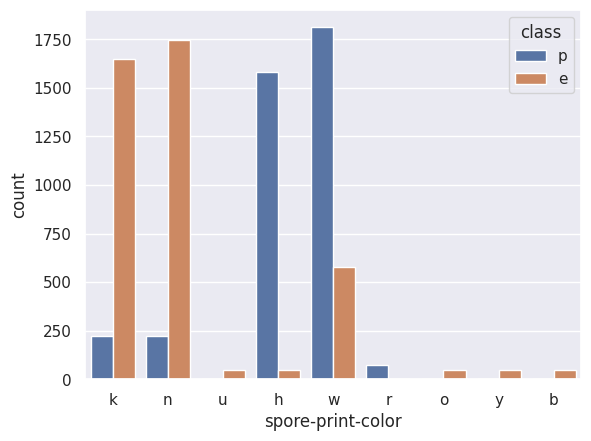

In [22]:
new_df.groupby('spore-print-color')['class'].value_counts()
sns.countplot(x="spore-print-color",data=new_df, hue='class')

<Axes: xlabel='spore-print-color', ylabel='count'>

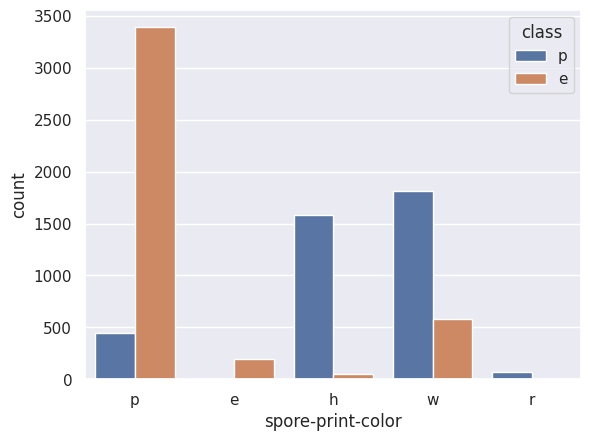

In [23]:
new_df['spore-print-color'] = new_df['spore-print-color'].replace(['u','o','y','b'], 'e')
new_df['spore-print-color'] = new_df['spore-print-color'].replace(['k','n'], 'p')
sns.countplot(x="spore-print-color",data=new_df, hue='class')

# new_df.drop('spore-print-color', axis=1, inplace = True)

In [24]:
# Now the unique values of each column has reduced significantly

new_df.nunique()

odor                 3
spore-print-color    5
class                2
dtype: int64

# One hot Encoding and Label Encoding then split the dataset

In [25]:
y = new_df['class']
X = new_df.drop(['class'], axis = 1)

In [26]:
#Splitting the dataset
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.25, random_state=7)

In [27]:
# One hot encoding

ohe = OneHotEncoder(drop='first')
data = ohe.fit_transform(X_train)

print(ohe.categories_)
print('___')
print(ohe.get_feature_names_out())
# pd.DataFrame(data.toarray(), columns = ohe.get_feature_names_out())

data_test = ohe.transform(X_test)

[array(['b', 'c', 'n'], dtype=object), array(['e', 'h', 'p', 'r', 'w'], dtype=object)]
___
['odor_c' 'odor_n' 'spore-print-color_h' 'spore-print-color_p'
 'spore-print-color_r' 'spore-print-color_w']


In [28]:
# Label Encoder for Output
le = LabelEncoder()

y_tr = le.fit_transform(y_train)
y_te = le.transform(y_test)

print(le.classes_)
print('___')
print(le.transform(["e", "p"]))

['e' 'p']
___
[0 1]


# Create Model then fit and predict the data

**Creating and Testing Accuracy Model With KNN**

In [29]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(data, y_tr)

y_pred = clf.predict(data_test)

In [30]:
print(accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

0.9940915805022157
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1042
           1       1.00      0.99      0.99       989

    accuracy                           0.99      2031
   macro avg       0.99      0.99      0.99      2031
weighted avg       0.99      0.99      0.99      2031

[[1042    0]
 [  12  977]]


**Creating and Testing Accuracy Model With RandomForestClassifier**

In [31]:
random_forest = RandomForestClassifier()
random_forest.fit(data, y_tr)

ypred = random_forest.predict(data_test)

In [32]:
print(accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

0.9940915805022157
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1042
           1       1.00      0.99      0.99       989

    accuracy                           0.99      2031
   macro avg       0.99      0.99      0.99      2031
weighted avg       0.99      0.99      0.99      2031

[[1042    0]
 [  12  977]]


# Intrepration of the Confusion Matrix

> **We marked: predicted as 0 and actual as 1**
 
 $$ Confusion \; Matrix \; of \;sklearn \; looks \; like\; :  $$
  \begin{bmatrix}
     TN & FP \\
     FN & TP
  \end{bmatrix}
  
  From our model We got:
  
>   False Positive (Type 1) error = 0

>   False Negative (Type 2) error = 12

Hence, 12 mushroom are found to be poissionious in real, but model has intrepted as the mushroom is edible.
  
 